In [2]:
# import cupy as cp
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
import numpy as np
import pandas as pd
from py_vollib_vectorized import vectorized_implied_volatility
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from functions.estimators import MonteCarlo

### Comparison to FDM Prices

In [3]:
# Cases 1-3 parameters
F0 = np.array([1.0, 1.0, 0.05])
alpha = np.array([0.25, 0.25, 0.4])
nu = np.array([0.3, 0.3, 0.6])
rho = np.array([-0.8, -0.5, 0.0])
beta = np.array([0.3, 0.6, 0.3])
T = np.array([10.0, 10.0, 1.0])

# Strikes for each case
strikes_case1 = np.array([0.2, 0.4, 0.8, 1.0, 1.2, 1.6, 2.0]) * F0[0]
strikes_case2 = np.array([0.2, 0.4, 0.8, 1.0, 1.2, 1.6, 2.0]) * F0[1]
strikes_case3 = np.array([0.4, 0.8, 1.0, 1.2, 1.6, 2.0]) * F0[2]

strikes = np.array([strikes_case1, strikes_case2, strikes_case3], dtype=object)

In [ ]:
dataset = []
approximator = MonteCarlo()
for _ in range(50):
    for i in tqdm(range(len(F0)), desc="Simulating"):

        call_ivs = approximator.calc_price_and_iv(alpha=alpha[i], beta=beta[i], rho=rho[i], nu=nu[i], K_vector=strikes[i], F0=F0[i], T=T[i], no_of_sim=2000000, no_of_steps=1400, seed=None)
        # Append one row per strike
        for k in range(len(strikes[i])):
            dataset.append([
                alpha[i], beta[i], rho[i], nu[i], T[i], F0[i], strikes[i][k], call_ivs[k], calls[k]
            ])

df = pd.DataFrame(dataset, columns=['alpha', 'beta', 'rho', 'nu', 'T', 'F0', 'K', 'IV', 'price'])

In [5]:
# True FDM call prices 
true_call_prices_case1 = [0.84255, 0.68906, 0.40646, 0.28502, 0.18304, 0.05343, 0.01096]
true_call_prices_case2 = [0.82886, 0.66959, 0.39772, 0.29118, 0.20690, 0.10018, 0.05014]
true_call_prices_case3 = [0.04559, 0.04141, 0.03942, 0.03750, 0.03390, 0.03061]

# Convert to implied vols 
true_iv_case1 = vectorized_implied_volatility(true_call_prices_case1, F0[0], strikes_case1, T[0], r=0, flag='c', q=0, return_as='numpy', on_error='ignore')
true_iv_case2 = vectorized_implied_volatility(true_call_prices_case2, F0[1], strikes_case2, T[1], r=0, flag='c', q=0, return_as='numpy', on_error='ignore')
true_iv_case3 = vectorized_implied_volatility(true_call_prices_case3, F0[2], strikes_case3, T[2], r=0, flag='c', q=0, return_as='numpy', on_error='ignore')

true_iv_dict = {
    0: dict(zip(strikes_case1, true_iv_case1)),
    1: dict(zip(strikes_case2, true_iv_case2)),
    2: dict(zip(strikes_case3, true_iv_case3)),
}


In [ ]:
# Build lookup dictionary indexed by rho and strike
true_iv_lookup = {}
for case_idx, rho_val in enumerate(rho):
    for strike, iv in true_iv_dict[case_idx].items():
        true_iv_lookup[(rho_val, strike)] = iv

# Group by rho (since different for every case) and K
grouped = df.groupby(['rho', 'K'])

# calculate bias and var
results = []
for (rho_val, K_val), group in grouped:
    iv_mean = group['IV'].mean()
    iv_var = group['IV'].var()

    keys_for_rho = [k for (r, k) in true_iv_lookup.keys() if r == rho_val]
    closest_K = min(keys_for_rho, key=lambda x: abs(x - K_val))

    true_iv = true_iv_lookup.get((rho_val, closest_K), np.nan)
    bias = iv_mean - true_iv

    results.append([
        rho_val, K_val, iv_mean, iv_var, bias
    ])

results_df = pd.DataFrame(results, columns=['rho', 'K', 'IV_mean', 'IV_var', 'Bias'])
results_df.to_csv("monte_carlo_error_results.csv", index=False)

### Median Error Grid

In [ ]:
# Import recomputed dataset for parameter combinations 2000-3000, and recomputed hedging dataset for parameter combinations 1-1000
with open("data generation/test pickles/recomputed_iv_dataset.pkl", "rb") as f0:
    chunks_recomputed_iv = pickle.load(f0)
with open("data generation/test pickles/recomputed_dataset_hedging.pkl", "rb") as f0:
    chunks_recomputed_iv_hedging = pickle.load(f0)
for chunk in chunks_recomputed_iv_hedging:
    chunk.rename(columns={"iv_base": "recomputed_IV"}, inplace=True)

In [4]:
# Merge recomputet hedging dataset and recomputet IV dataset to get to 3000 parameter combinations
chunks = chunks_recomputed_iv + chunks_recomputed_iv_hedging

In [5]:
df = pd.concat(chunks, ignore_index=True)
df["moneyness"] = df["strike_price"] / df["forward_price"]
df = df.loc[~((df["recomputed_IV"] == 0) | (df["recomputed_IV"].isna()) | (np.isinf(df["recomputed_IV"])))]
df['error_mc'] = np.abs((df['recomputed_IV'] - df['impl_volatility']) / df['impl_volatility']) * 100

In [6]:
print(np.median(df['error_mc']))

0.29370113016404226


/var/folders/x2/wtthh7_97c7c3r0cyqd569zc0000gn/T/ipykernel_19504/430577420.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(['T_bin', 'strike_bin'])[error_col].median().unstack()


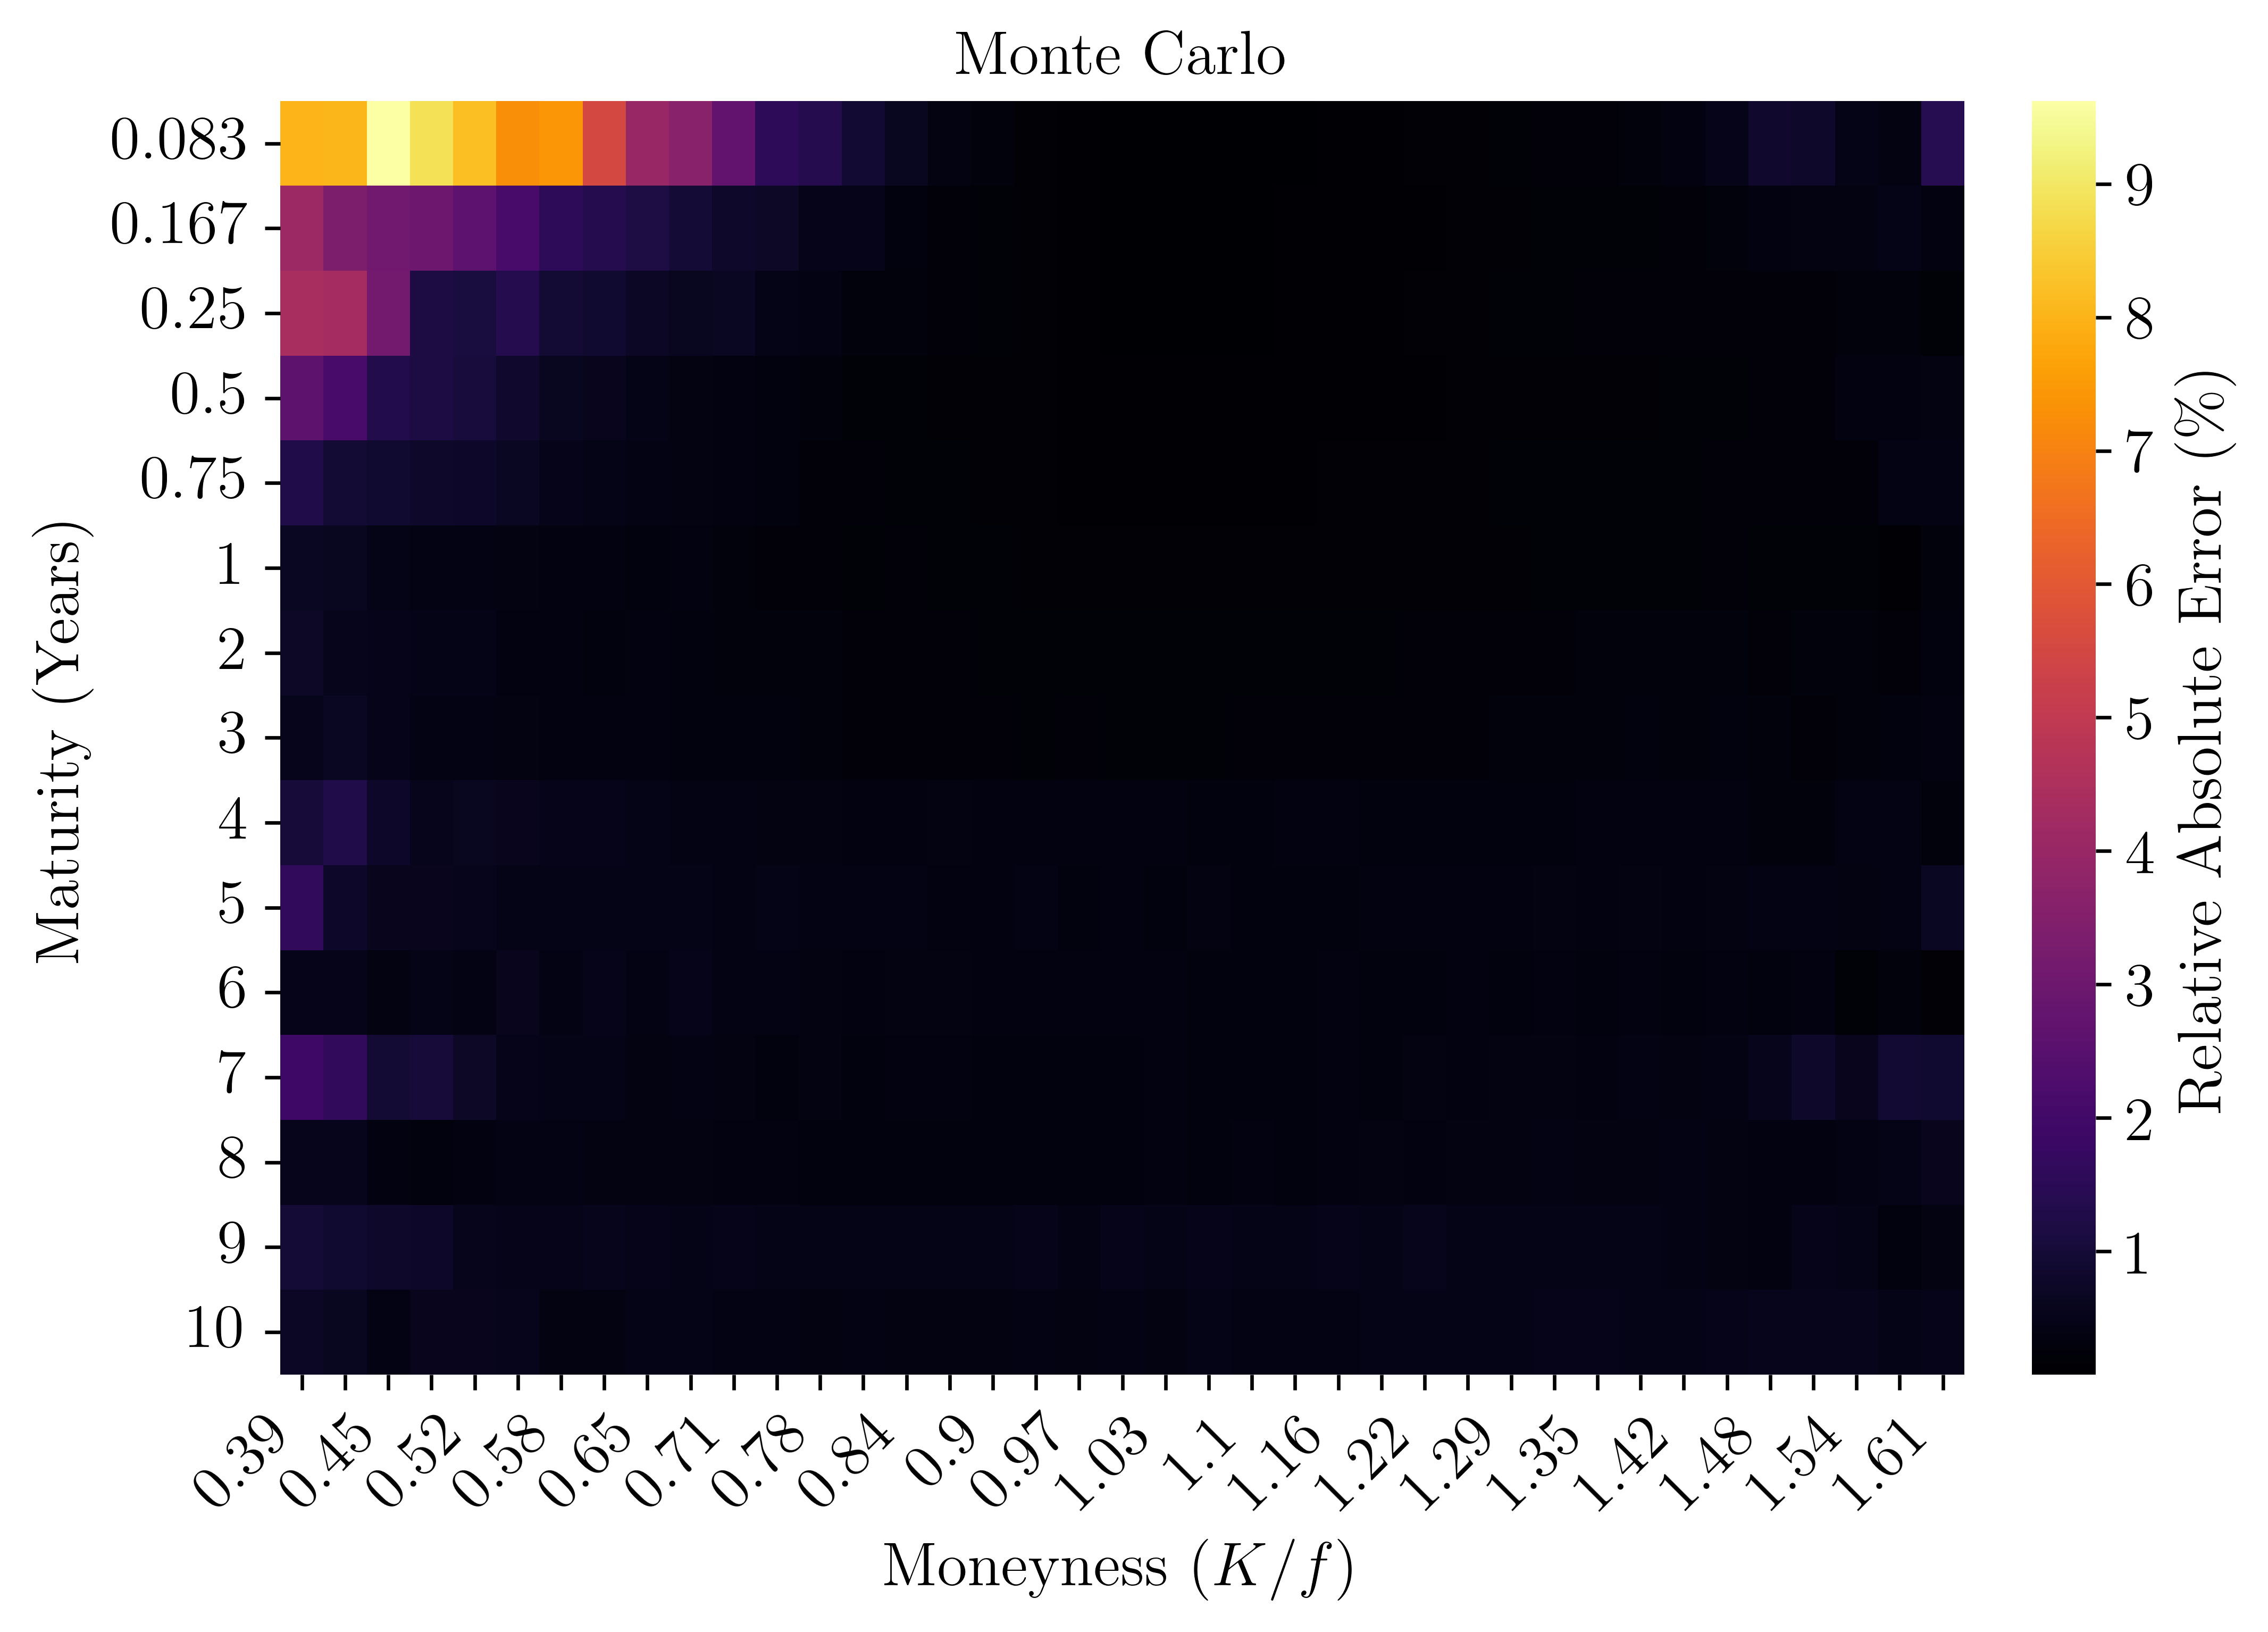

In [8]:
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Latin Modern Roman'],
    'font.size': 14,
    'font.weight': 'bold',
    'axes.titlesize': 14,
    'axes.titleweight': 'bold', 
    'axes.labelsize': 14,
    'axes.labelweight': 'bold', 
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14,
    'legend.title_fontsize': 14,
    'text.usetex': True,  
})

unique_T = sorted(df['T'].unique())
strike_bins = np.linspace(df['moneyness'].min(), df['moneyness'].max(), 40)
df['strike_bin'] = pd.cut(df['moneyness'], bins=strike_bins)
df['T_bin'] = pd.Categorical(df['T'], categories=unique_T, ordered=True)

error_col = 'error_mc'
title = 'Monte Carlo'

custom_ticks = [1, 2, 3, 4, 5, 6, 7, 8, 9]

fig, ax = plt.subplots(figsize=(7, 5), constrained_layout=True, dpi=600)

grouped = df.groupby(['T_bin', 'strike_bin'])[error_col].median().unstack()
Z = grouped.values
Z = np.where(Z <= 0, np.nan, Z)

T_labels = [("{:.3f}".format(float(t))).rstrip('0').rstrip('.') for t in grouped.index]
strike_labels = [round(interval.mid, 2) for interval in grouped.columns]
strike_labels = [lbl if i % 2 == 0 else "" for i, lbl in enumerate(strike_labels)]

vmin = np.nanmin(Z)
vmax = np.nanmax(Z)

heatmap = sns.heatmap(
    Z, ax=ax, cmap="inferno", cbar=True,
    xticklabels=strike_labels, yticklabels=T_labels,
    vmin=vmin, vmax=vmax,
    cbar_kws={"pad": 0.04}
)

cbar = heatmap.collections[0].colorbar
cbar.set_ticks(custom_ticks)
cbar_labels = [
    str(int(t)) if float(t).is_integer() else str(t)
    for t in custom_ticks
]
cbar.set_ticklabels(cbar_labels)
cbar.set_label(r"Relative Absolute Error (\%)")

ax.set_title(title)
ax.set_xlabel("Moneyness ($K$/$f$)")
ax.set_ylabel("Maturity (Years)")

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha="right")

plt.show()